# **Importing Library**
# **Connect to Google Drive**
# **Checking GPU Availability**

In [1]:
import os
import shutil
import zipfile
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#UNCOMMENT THIS IF YOU WANT TO USE GOOGLE COLAB AND GOOGLE DRIVE
# from google.colab import drive
# drive.mount('/content/drive')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# **Directory**

In [2]:
# YOU NEED TO CHANGE THIS BEFORE YOU RUN THIS NOTEBOOK

# CHANGE THIS VARIABLE TO YOUR MAIN DIRECTORY (MAIN DIRECTORY MUST BE CREATED MANUALLY)
main_dir = os.getcwd()

# CHANGE THIS VARIABLE TO YOUR "kaggle.json" FILE DIRECTORY (IF YOU WANT TO DOWNLOAD THE DATASET FROM KAGGLE)
token_kaggle_API_dir = main_dir

In [3]:
dataset_dir = os.path.join(main_dir, 'dataset')

training_dir   = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')
testing_dir    = os.path.join(dataset_dir, 'testing')

# **DOWNLOAD AND EXTRACT THE DATASET FROM KAGGLE (GANTI JUDULNYA)**

In [6]:
kaggle_dir = os.path.join(main_dir, 'Data Kaggle')
data_tmp_dir = os.path.join(kaggle_dir, 'datatmp')

In [ ]:
!pip install kaggle

os.environ['KAGGLE_CONFIG_DIR'] = token_kaggle_API_dir

try:
  os.mkdir(kaggle_dir)
  os.chdir(kaggle_dir)
  !kaggle datasets download -d andrewmvd/pothole-detection
  !kaggle datasets download -d chitholian/annotated-potholes-dataset
  !kaggle datasets download -d sovitrath/road-pothole-images-for-pothole-detection
  print("DATASETS HAS BEEN DOWNLOADED!")
except:
  print("DATASETS ALREADY DOWNLOADED!")

 97% 326M/334M [00:03<00:00, 120MB/s]
100% 334M/334M [00:03<00:00, 106MB/s]
 72% 33.0M/45.9M [00:00<00:00, 37.9MB/s]
100% 45.9M/45.9M [00:00<00:00, 78.3MB/s]
100% 8.81G/8.82G [02:19<00:00, 54.9MB/s]
100% 8.82G/8.82G [02:23<00:00, 65.8MB/s]
DATASETS HAS BEEN DOWNLOADED!


In [9]:
for file in os.listdir(kaggle_dir):
    if file.endswith('.zip'):
        print(file)

annotated-potholes-dataset.zip
archive.zip
pothole-detection.zip


In [13]:
try:
  os.mkdir(data_tmp_dir)
  for file in os.listdir(kaggle_dir):
    if file.endswith('.zip'):
      zipfile.ZipFile(os.path.join(kaggle_dir, file), 'r').extractall(data_tmp_dir)
  print("DATASETS HAS BEEN EXTRACTED!")
except:
  print("DATASETS ALREADY EXTRACTED!")

DATASETS HAS BEEN EXTRACTED!


# **Data Combininig**

In [14]:
kaggle_dir = os.path.join(main_dir, 'Data Kaggle')
data_tmp_dir = os.path.join(kaggle_dir, 'datatmp')

dataset_tmp_dir = os.path.join(kaggle_dir, 'datasettmp')
positive_tmp_dir = os.path.join(dataset_tmp_dir, 'Positive data')
negative_tmp_dir = os.path.join(dataset_tmp_dir, 'Negative data')

source1 = os.path.join(data_tmp_dir, 'Dataset 1 (Simplex)', 'Dataset 1 (Simplex)', 'Train data')
source2 = os.path.join(data_tmp_dir, 'Dataset 1 (Simplex)', 'Dataset 1 (Simplex)', 'Test data')
source3 = os.path.join(data_tmp_dir, 'images')
source4 = os.path.join(data_tmp_dir, 'annotated-images')

In [15]:
def copyDir(SOURCE, DESTINATION, EXCEPT=[], DEL_DEST=False):
  if DEL_DEST:
    try:
      shutil.rmtree(DESTINATION)
    except:
      pass
    os.mkdir(DESTINATION)

  listfile = os.listdir(SOURCE)
  listfile = [file for file in listfile if file not in EXCEPT]
  for file in listfile:
    spath = os.path.join(SOURCE, file)
    dpath = os.path.join(DESTINATION, file)
    if os.path.isdir(spath):
      copyDir(spath, dpath, EXCEPT, DEL_DEST)
    else:
      shutil.copy(spath, dpath)

In [16]:
try:
  os.mkdir(dataset_tmp_dir)
  copyDir(source1, dataset_tmp_dir, DEL_DEST=True)
  copyDir(source2, positive_tmp_dir)
  copyDir(source3, positive_tmp_dir)
  copyDir(source4, positive_tmp_dir, [xml for xml in os.listdir(source4) if xml.endswith('.xml')])
  print('DATASETS HAS BEEN COMBINED!')
except:
  print('DATASETS ALREADY COMBINED!')

DATASETS HAS BEEN COMBINED!


In [17]:
print('TOTAL DATASETS:')
print('pothole data:', len(os.listdir(positive_tmp_dir)))
print('normal data:', len(os.listdir(negative_tmp_dir)))

TOTAL DATASETS:
pothole data: 3077
normal data: 2658


# **Data Splitting**

In [18]:
kaggle_dir = os.path.join(main_dir, 'Data Kaggle')
dataset_tmp_dir = os.path.join(kaggle_dir, 'datasettmp')
positive_tmp_dir = os.path.join(dataset_tmp_dir, 'Positive data')
negative_tmp_dir = os.path.join(dataset_tmp_dir, 'Negative data')

dataset_tmp_dir = os.path.join(kaggle_dir, 'datasettmp')
positive_tmp_dir = os.path.join(dataset_tmp_dir, 'Positive data')
negative_tmp_dir = os.path.join(dataset_tmp_dir, 'Negative data')

positive_training_dir   = os.path.join(training_dir, 'positive')
positive_validation_dir = os.path.join(validation_dir, 'positive')
positive_testing_dir    = os.path.join(testing_dir, 'positive')
negative_training_dir   = os.path.join(training_dir, 'negative')
negative_validation_dir = os.path.join(validation_dir, 'negative')
negative_testing_dir    = os.path.join(testing_dir, 'negative')

In [19]:
def split_data(SOURCE, TRAINING, VALIDATION, TESTING, SPLIT_SIZE=[0.8, 0.15, 0.05]):
  def copy(SOURCE, DESTINATION, NAME):
    source_file = os.path.join(SOURCE, NAME)
    destination_file = os.path.join(DESTINATION, NAME)
    shutil.copy(source_file, destination_file)
  
  FILES = os.listdir(SOURCE)
  FILES = np.random.choice(FILES, len(FILES))

  split1 = int(len(FILES) * split_size[0])
  split2 = split1 + int(len(FILES) * split_size[1])

  training_file   = FILES[:split1]
  validation_file = FILES[split1:split2]
  testing_file    = FILES[split2:]

  for file_name in training_file:
    copy(SOURCE, TRAINING, file_name)
  for file_name in validation_file:
    copy(SOURCE, VALIDATION, file_name)
  for file_name in testing_file:
    copy(SOURCE, TESTING, file_name)

In [20]:
try:
  os.mkdir(dataset_dir)
  os.mkdir(training_dir)
  os.mkdir(validation_dir)
  os.mkdir(testing_dir)
  os.mkdir(positive_training_dir)
  os.mkdir(positive_validation_dir)
  os.mkdir(positive_testing_dir)
  os.mkdir(negative_training_dir)
  os.mkdir(negative_validation_dir)
  os.mkdir(negative_testing_dir)

  split_size = [0.8, 0.15, 0.05]
  split_data(positive_tmp_dir, positive_training_dir, positive_validation_dir, positive_testing_dir, split_size)
  split_data(negative_tmp_dir, negative_training_dir, negative_validation_dir, negative_testing_dir, split_size)

  print('DATASETS HAS BEEN SPLITTED!')
except:
  print('DATASETS ALREADY SPLITTED!')

DATASETS HAS BEEN SPLITTED!


In [21]:
print('TOTAL DATASETS AFTER SPLIT:')
print('pothole training:', len(os.listdir(positive_training_dir)))
print('pothole validation:', len(os.listdir(positive_validation_dir)))
print('pothole test:', len(os.listdir(positive_testing_dir)))
print()
print('normal training:', len(os.listdir(negative_training_dir)))
print('normal validation:', len(os.listdir(negative_validation_dir)))
print('normal test:', len(os.listdir(negative_testing_dir)))

TOTAL DATASETS AFTER SPLIT:
pothole training: 1685
pothole validation: 435
pothole test: 151

normal training: 1483
normal validation: 368
normal test: 134


# **Data Visualization** 

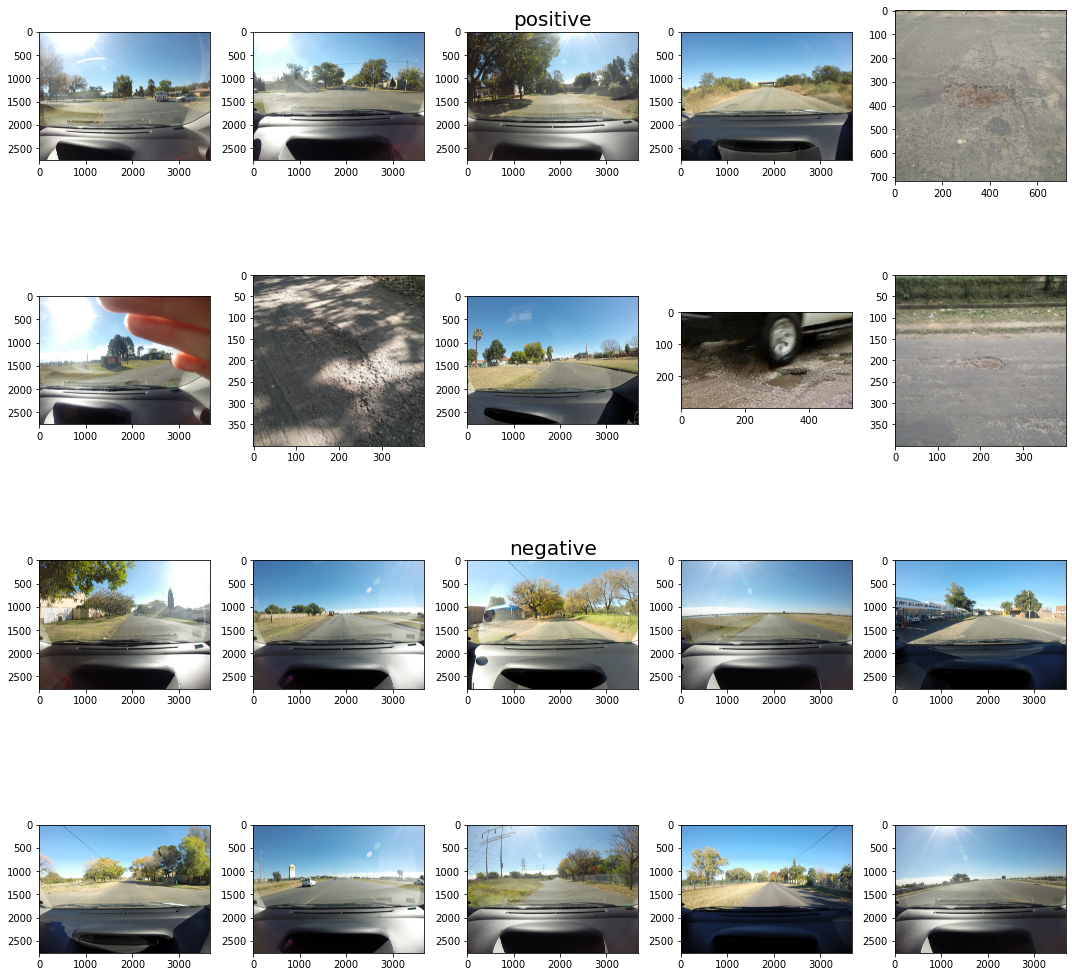

In [22]:
# Display 5 random images

plt.figure(0, figsize=(15,15))
n_rows = 4
n_cols = 5
position = 0

for type in ['positive', 'negative']:
    plt.subplot(n_rows, n_cols, position + int(n_cols / 2) + 1)
    plt.title(type, fontsize=20)
    
    hole_path = os.path.join(training_dir, type)
    rand = np.random.choice(os.listdir(hole_path), n_cols*2)
    for path in rand:
        image_path = os.path.join(hole_path, path)
        img = mpimg.imread(image_path)
        
        position += 1
        plt.subplot(n_rows, n_cols, position)
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

NANTI TARO ATAS

In [4]:
MODULE_HANDLE = "https://tfhub.dev/tensorflow/efficientnet/lite0/classification/2"
IMAGE_SIZE = (224, 224)

# **Image Preprocessing**

In [13]:
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    training_dir,
    target_size=IMAGE_SIZE,
    # target_size=(50, 50),
    # color_mode='grayscale',
    # class_mode='binary',
    class_mode='categorical',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    # target_size=(50, 50),
    # color_mode='grayscale',
    # class_mode='binary',
    class_mode='categorical',
    batch_size=32
)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    shuffle=True,
    target_size=IMAGE_SIZE,
    # target_size=(50, 50),
    # target_size=(150, 150),
    # color_mode='rgb',
    # color_mode='grayscale',
    # class_mode='binary',
    class_mode='categorical',
    # class_mode=None,
    batch_size=32
)

Found 3168 images belonging to 2 classes.
Found 803 images belonging to 2 classes.
Found 285 images belonging to 2 classes.


# **Importing Model**

In [14]:
pretrain = hub.KerasLayer(MODULE_HANDLE, input_shape=IMAGE_SIZE + (3,))

In [15]:
model = tf.keras.Sequential([
    pretrain,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dense(1, activation='sigmoid')
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1000)              4694024   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               128128    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 130       
Total params: 4,830,538
Trainable params: 136,514
Non-trainable params: 4,694,024
_________________________________________________________________


# **Training Model**

In [16]:
model_out_dir = os.path.join(main_dir, 'output_model')
checkpoint_dir = os.path.join(model_out_dir, 'checkpoint', 'model_weights')
try:
  os.mkdir(model_out_dir)
except:
  pass

In [17]:
op = tf.keras.optimizers.Adam(learning_rate=0.001)
op1 = tf.keras.optimizers.RMSprop(learning_rate=0.001)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_dir,
    monitor = 'val_acc',
    verbose = 1,
    save_best_only = True,
    save_weights_only=True,
    mode = 'max'
)

class stopIt(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.9):
            if(logs.get('val_acc')>0.9):
                print("\nReached 90% accuracy so cancelling training!"
                self.model.stop_training = True

model.compile(
    # optimizer = 'rmsprop',
    # optimizer = 'adam',
    optimizer = op,
    # loss = 'binary_crossentropy',
    loss = 'categorical_crossentropy',
    metrics = ['acc']
)

In [18]:
history = model.fit(
    train_generator,
    epochs = 10,
    # steps_per_epoch = 5,
    steps_per_epoch = train_generator.n//train_generator.batch_size,
    validation_data = validation_generator,
    # verbose = 1,
    # validation_steps = 2,
    validation_steps = validation_generator.n//validation_generator.batch_size,
    callbacks = [checkpoint, stopIt()]
)

Epoch 1/10
99/99 [==============================] - 358s 4s/step - loss: 0.5693 - acc: 0.7282 - val_loss: 0.3893 - val_acc: 0.8125

Epoch 00001: val_acc improved from -inf to 0.81250, saving model to c:\Users\aadaa\Documents\Kuliah\Bangkit\Final Project\Pothole Detection\training\output_model\checkpoint\model_weights
Epoch 2/10
99/99 [==============================] - 351s 4s/step - loss: 0.4589 - acc: 0.7664 - val_loss: 0.3733 - val_acc: 0.8100

Epoch 00002: val_acc did not improve from 0.81250
Epoch 3/10
99/99 [==============================] - 350s 4s/step - loss: 0.4183 - acc: 0.7955 - val_loss: 0.3326 - val_acc: 0.8537

Epoch 00003: val_acc improved from 0.81250 to 0.85375, saving model to c:\Users\aadaa\Documents\Kuliah\Bangkit\Final Project\Pothole Detection\training\output_model\checkpoint\model_weights
Epoch 4/10
99/99 [==============================] - 419s 4s/step - loss: 0.4119 - acc: 0.7989 - val_loss: 0.3293 - val_acc: 0.8612

Epoch 00004: val_acc improved from 0.85375 to

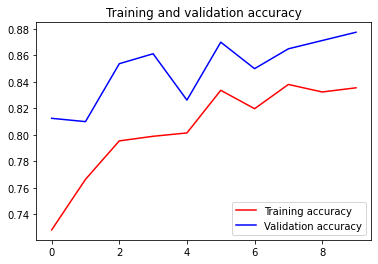

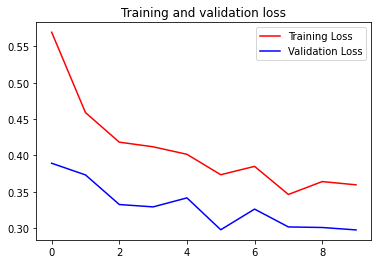

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
# Load the best weight
model.load_weights(checkpoint_dir)

In [15]:
# FOR TESTING PURPOSE
# model = tf.keras.models.load_model(os.path.join(main_dir, "model2", "full model"))

# **Evaluating Model**

In [20]:
# Evaluate the model
print('Evaluate on training data')
model.evaluate(train_generator, verbose=1)

print('Evaluate on validation data')
model.evaluate(validation_generator, verbose=1)

print('Evaluate on test data')
model.evaluate(test_generator, verbose=1)

Evaluate on training data
99/99 [==============================] - 391s 4s/step - loss: 0.3031 - acc: 0.8703
Evaluate on validation data
26/26 [==============================] - 86s 3s/step - loss: 0.2976 - acc: 0.8780
Evaluate on test data
9/9 [==============================] - 28s 3s/step - loss: 0.3129 - acc: 0.8807


[0.3128662109375, 0.8807017803192139]

In [ ]:
test_img = test_generator.next()

In [ ]:
# test_img = test_generator.next()
pred = model.predict(test_img[0])
res = [[pred[i][0], test_img[1][i]] for i in range(len(pred))]
res.sort(reverse=True)
print('No\t Prediction\t Actual')
for i in range(len(pred)):
  print(i+1, '\t', res[i][0], '\t', res[i][1])

No	 Prediction	 Actual
1 	 0.9973158 	 1.0
2 	 0.99703985 	 1.0
3 	 0.9952282 	 1.0
4 	 0.99329257 	 1.0
5 	 0.9916156 	 1.0
6 	 0.98822314 	 1.0
7 	 0.9868515 	 1.0
8 	 0.98202056 	 1.0
9 	 0.98179644 	 1.0
10 	 0.97900385 	 1.0
11 	 0.97464263 	 1.0
12 	 0.97315514 	 1.0
13 	 0.96682256 	 1.0
14 	 0.9377062 	 1.0
15 	 0.9054051 	 1.0
16 	 0.89937025 	 1.0
17 	 0.8601111 	 1.0
18 	 0.80939573 	 1.0
19 	 0.69613713 	 1.0
20 	 0.5280761 	 1.0
21 	 0.3450193 	 0.0
22 	 0.3166208 	 0.0
23 	 0.2872639 	 0.0
24 	 0.26240745 	 0.0
25 	 0.22856371 	 0.0
26 	 0.20518048 	 0.0
27 	 0.19324337 	 0.0
28 	 0.19094378 	 0.0
29 	 0.18685937 	 0.0
30 	 0.17648722 	 0.0
31 	 0.15578832 	 0.0
32 	 0.13490602 	 0.0


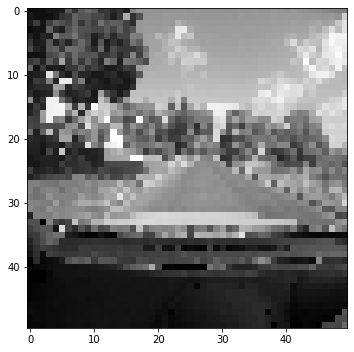

In [ ]:
plt.figure(0, figsize=(5, 5))
for img in test_img[0]:
  plt.imshow(img[:, :, 0], cmap='gray')
plt.tight_layout()
plt.show()

# **Saving and Converting Model to TF Lite**

In [21]:
model.save(os.path.join(model_out_dir, 'full model'))

INFO:tensorflow:Assets written to: c:\Users\aadaa\Documents\Kuliah\Bangkit\Final Project\Pothole Detection\training\output_model\full model\assets
INFO:tensorflow:Assets written to: c:\Users\aadaa\Documents\Kuliah\Bangkit\Final Project\Pothole Detection\training\output_model\full model\assets


In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(os.path.join(model_out_dir, 'model.tflite'), 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\aadaa\AppData\Local\Temp\tmpj59d6sdk\assets
INFO:tensorflow:Assets written to: C:\Users\aadaa\AppData\Local\Temp\tmpj59d6sdk\assets
